In [ ]:
# !pip install torch torchvision timm pandas scikit-learn opencv-python

In [3]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np

In [4]:
# --- CONFIG ---
IMG_SIZE = 299  # as per paper
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_DIR = r'D:/Kaif/Hackathon25/CDAC/1000images/1000images'


In [5]:
# --- LABEL ENCODING ---
all_dirs = sorted(os.listdir(ROOT_DIR))
class_names = [d for d in all_dirs if os.path.isdir(os.path.join(ROOT_DIR, d))]
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit([class_names])  # fit one-hot encoder

,classes,"['0.0.Normal', '0.1.Tessellated fundus', ...]"
,sparse_output,False


In [6]:
# --- CUSTOM DATASET ---
class FundusMultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for cls in class_names:
            folder = os.path.join(root_dir, cls)
            imgs = glob.glob(os.path.join(folder, "*.JPG"))
            self.image_paths.extend(imgs)
            self.labels.extend([[cls]] * len(imgs))  # list of one class per image

        self.encoded_labels = mlb.transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = torch.FloatTensor(self.encoded_labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, label


In [7]:
# --- TRANSFORMS ---
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [10]:
len(dataset)

997

In [9]:
# --- DATA LOADER ---
dataset = FundusMultiLabelDataset(ROOT_DIR, transform=train_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

In [11]:
# --- MODEL: INCEPTION RESNET V2-like substitute ---
model = models.inception_v3(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, len(class_names)),
    nn.Sigmoid()  # for multi-label output
)
model = model.to(DEVICE)

d:\Kaif\Hackathon25\CDAC\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Kaif\Hackathon25\CDAC\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# --- LOSS + OPTIMIZER ---
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [13]:
def train_model():
    best_loss = float('inf')
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            if isinstance(outputs, tuple):  # Inception outputs (main, aux)
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f"Validation Loss: {val_loss:.4f}")
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_fundus_multilabel.pth")
            print("✅ Saved best model!")


In [51]:
train_model()

Epoch 1/20: 100%|██████████| 100/100 [12:05<00:00,  7.26s/it]


Epoch 1, Loss: 24.9780
Validation Loss: 2.7306
✅ Saved best model!


Epoch 2/20: 100%|██████████| 100/100 [32:22<00:00, 19.42s/it]  


Epoch 2, Loss: 10.1498
Validation Loss: 2.2157
✅ Saved best model!


Epoch 3/20: 100%|██████████| 100/100 [15:24<00:00,  9.25s/it]


Epoch 3, Loss: 8.4487
Validation Loss: 1.8453
✅ Saved best model!


Epoch 4/20: 100%|██████████| 100/100 [15:05<00:00,  9.05s/it]


Epoch 4, Loss: 7.2103
Validation Loss: 1.6614
✅ Saved best model!


Epoch 5/20: 100%|██████████| 100/100 [09:50<00:00,  5.90s/it]


Epoch 5, Loss: 6.1673
Validation Loss: 1.2337
✅ Saved best model!


Epoch 6/20:   4%|▍         | 4/100 [00:21<08:25,  5.27s/it]


KeyboardInterrupt: 

In [14]:
# --- LOAD TRAINED MODEL ---
model = models.inception_v3(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, len(class_names)),
    nn.Sigmoid()
)
model.load_state_dict(torch.load("best_fundus_multilabel_1.pth", map_location=DEVICE))
model = model.to(DEVICE)
model.eval()


d:\Kaif\Hackathon25\CDAC\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\Kaif\Hackathon25\CDAC\venv\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [39]:
import matplotlib.pyplot as plt

def predict_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])

    # Load and show the image before prediction
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocess and predict
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        if isinstance(output, tuple):  # Handle Inception aux outputs
            output = output[0]
        preds = output.squeeze().cpu().numpy()

    # Apply threshold
    threshold = 0.1
    binary_preds = preds > threshold

    # Decode predictions
    print("Raw Scores:", preds)
    predicted_labels = mlb.inverse_transform(np.array([binary_preds]))[0]

    print(f"🔍 Predicted Labels: {predicted_labels}")
    return predicted_labels


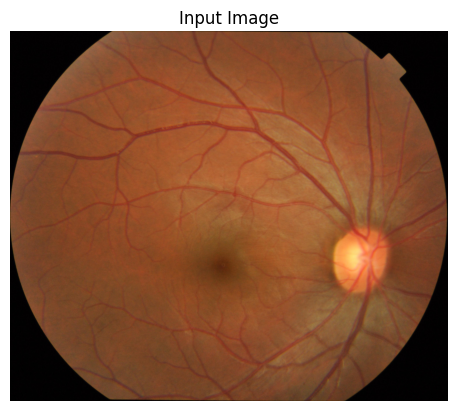

Raw Scores: [0.00967086 0.00877227 0.04717212 0.01576465 0.01442319 0.00705432
 0.00987603 0.00934378 0.01217916 0.01194409 0.00655052 0.01261457
 0.01444459 0.00609824 0.00620761 0.00897155 0.00584666 0.00605855
 0.01204218 0.00509044 0.00786803 0.0188961  0.0080441  0.0110314
 0.01484678 0.00987207 0.00750574 0.00948087 0.01525476 0.11379418
 0.02071817 0.01464502 0.00824572 0.01361375 0.00808052 0.02995186
 0.02287979 0.02180229 0.01348495]
🔍 Predicted Labels: ('29.0.Blur fundus without PDR',)


('29.0.Blur fundus without PDR',)

In [40]:
sample_image_path = r'D:/Kaif/Hackathon25/CDAC/1000images/0.0.Normal/1ffa9629-8d87-11e8-9daf-6045cb817f5b..JPG'  # Replace with your test image path
predict_image(sample_image_path)


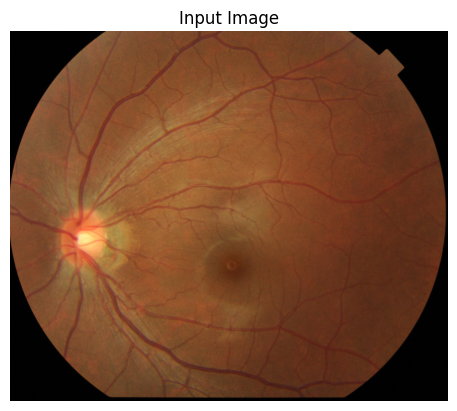

Raw Scores: [0.01199338 0.00827717 0.03058993 0.01341991 0.01332604 0.0051666
 0.01069703 0.00762546 0.00866065 0.01186258 0.00743189 0.00927736
 0.01472506 0.00542758 0.00526305 0.00715587 0.0052214  0.00471791
 0.01235563 0.00601124 0.00520221 0.01448641 0.00794695 0.01311302
 0.00849305 0.00653466 0.00582216 0.00649358 0.00972523 0.26900294
 0.01633669 0.00913257 0.0071814  0.00935974 0.00471679 0.01523839
 0.02320563 0.04135749 0.00777082]
🔍 Predicted Labels: ('29.0.Blur fundus without PDR',)


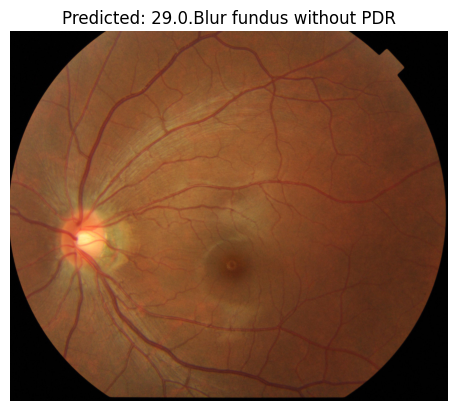

In [48]:
import matplotlib.pyplot as plt

def show_prediction(image_path):
    labels = predict_image(image_path)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {', '.join(labels) if labels else 'None'}")
    plt.show()

show_prediction(r'D:\Kaif\Hackathon25\CDAC\1000images\0.0.Normal\1ffa9647-8d87-11e8-9daf-6045cb817f5b..JPG')
